## Relative performance

* If the test set is small then the variability of the test error might be larger than the actual difference between two models. 
* To sidestep this issue we can estimate the relative performance using a large amount of unlabelled data   

See the notebook [relative_performance.ipynb](./tutorials/relative_performance.ipynb) for theoretical background. 


In [1]:
%config IPCompleter.greedy=True

In [1]:
import numpy as np
import pandas as pd

from pandas import Series
from pandas import DataFrame

from tqdm.notebook import trange
from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression

from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Experiment setup

We are going to estimate which of two models performs better using only a small set of data points which we have to label.
We  compare this with the standard setup where we estimate absolute performance of models on a large test set to see how well the relative performance evaluation really works. 
For simplicity, we use logistic regression as way to train models.  

* We generate data that satisfies a simple relation $y=x_1$ with probability $\alpha$ and $y=\neg x_1$ with probability $1-\alpha$.
* By varying the $\alpha$ over the range $[0, 0.5]$ we can create learning tasks with different complexity.

In [2]:
def sampler(n:int, k:int, alpha) -> DataFrame:
    columns = ['x_{}'.format(num) for num in range(1, k + 1)]
    return (DataFrame(random.rand(n, k), columns = columns)
            .transform(lambda x: x >= 0.5)
            .assign(y = lambda df: df['x_1'] ^ (np.random.random(n) < alpha)))

Let us first study how does the test error changes so that we can get an idea which models to choose for relative comparison. 
* We aim for two models with small difference in their accuracy.
* The difference shpuld be small enough so that the est error fluctuations are comparable.

  0%|          | 0/99 [00:00<?, ?it/s]

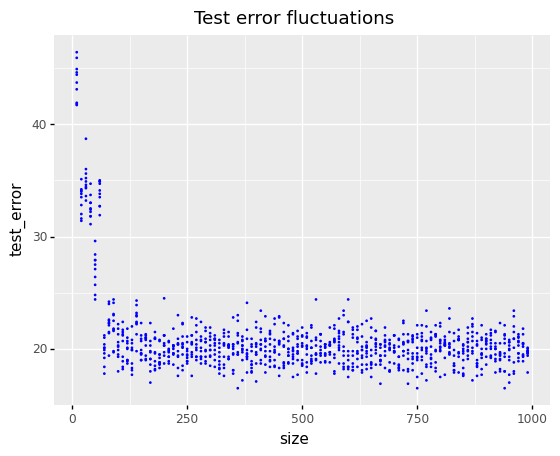

<ggplot: (383638468)>

In [11]:
k = 8
r = 10
alpha = 0.8
sizes = list(range(10, 1000, 10))
clf_1 = LogisticRegression(solver = 'lbfgs')
features =['x_{}'.format(i+1) for i in range(k)]

results = (combine_categories({'size': sizes,  'experiment': list(range(r))})
           .assign(test_error=np.nan)
           .set_index(['size', 'experiment']))

for size in tqdm(sizes):
    training_set = sampler(size, k, alpha)
    clf_1.fit(training_set[features], training_set['y'])
    for exp in range(r):
        test_set = sampler(1000, k, alpha)
        results.loc[(size, exp),'test_error'] = empirical_risk(clf_1, test_set[features], test_set['y'])
    
# display(head(results))

p = ggplot(results.reset_index()) 
p = p + geom_point(aes(x='size', y='test_error'), color='blue', size=0.1)
p = p + ggtitle('Test error fluctuations')
display(p)

* From training set size 200 the change in the test error is not observable as the test error fluctuations are larger than the accuracy improvement.  
* In particular, it is not clear whether there is a difference if we use 200 or 1000 datapoints for training. 

# Homeworks

## 11.1 Relative performance  (<font color='red'>2p</font>)

Train two logistic regression models on the datasets of size 200 and 1000 datapoints. Estimate their test error variability by sampling 100 different datasets of size 1000 and 100000 elements. Draw the corresponding jitter plot (`geom_jitter`) to see if test set sizes are large enough to reveal the differences in accuracy (<font color='red'>0.5p</font>). 
Next, take a large enough test and evaluate both classifiers on the inputs and select 1000 data points for which the corresponding labels differ. Based on that estimate what is the maximal theoretical difference between classifiers.  After that use labels to estimate the relative performance difference between classifiers (<font color='red'>0.5p</font>). Use moment matching to get error bound on the relative difference. For that you can assume that the relative size $p$ of datapoints that have different labels is precisely measured, i.e., $p$ does not fluctuate (<font color='red'>1p</font>).